In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-cars-price-prediction/test-data.csv
/kaggle/input/used-cars-price-prediction/train-data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use(style='ggplot')

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
import xgboost as xgb
import torch 
import torch.nn as nn

In [6]:
%config Completer.use_jedi = False

In [7]:
train_data = pd.read_csv('../input/used-cars-price-prediction/train-data.csv')
test_data = pd.read_csv('../input/used-cars-price-prediction/test-data.csv')


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1234 non-null   int64  
 1   Name               1234 non-null   object 
 2   Location           1234 non-null   object 
 3   Year               1234 non-null   int64  
 4   Kilometers_Driven  1234 non-null   int64  
 5   Fuel_Type          1234 non-null   object 
 6   Transmission       1234 non-null   object 
 7   Owner_Type         1234 non-null   object 
 8   Mileage            1234 non-null   object 
 9   Engine             1224 non-null   object 
 10  Power              1224 non-null   object 
 11  Seats              1223 non-null   float64
 12  New_Price          182 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 125.5+ KB


In [10]:
test_data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN
1,1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN
2,2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh
3,3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0,NaN
4,4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN


## Missing values in train data

In [11]:
print(train_data.isnull().sum(),'\n')
print(test_data.isnull().sum())

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64 

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                 10
Power                  10
Seats                  11
New_Price            1052
dtype: int64


In [12]:
train_data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [13]:
train_data = train_data.iloc[:,1:]
test_data = test_data.iloc[:,1:]

In [14]:
train_data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [15]:
train_data.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


In [16]:
train_data.shape

(6019, 13)

In [17]:
train_data.head(15)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.1 km/kg,814 CC,55.2 bhp,5.0,NaN,2.35
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN,3.50
7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36 kmpl,2755 CC,171.5 bhp,8.0,21 Lakh,17.50
8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54 kmpl,1598 CC,103.6 bhp,5.0,NaN,5.20
9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.3 kmpl,1248 CC,74 bhp,5.0,NaN,1.95


In [18]:
y = train_data.Year.unique()
y.sort()
print(y)

[1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019]


## Data Cleaning

In [19]:
train_data.shape

(6019, 13)

In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               1234 non-null   object 
 1   Location           1234 non-null   object 
 2   Year               1234 non-null   int64  
 3   Kilometers_Driven  1234 non-null   int64  
 4   Fuel_Type          1234 non-null   object 
 5   Transmission       1234 non-null   object 
 6   Owner_Type         1234 non-null   object 
 7   Mileage            1234 non-null   object 
 8   Engine             1224 non-null   object 
 9   Power              1224 non-null   object 
 10  Seats              1223 non-null   float64
 11  New_Price          182 non-null    object 
dtypes: float64(1), int64(2), object(9)
memory usage: 115.8+ KB


In [22]:
train_data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [23]:
test_data.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                 10
Power                  10
Seats                  11
New_Price            1052
dtype: int64

In [24]:
train_data['Seats'].value_counts()

5.0     5014
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
0.0        1
Name: Seats, dtype: int64

In [25]:
zero_seat = train_data[train_data['Seats'] == 0].index
train_data.drop(zero_seat, axis=0, inplace=True)


In [26]:
train_data.drop('New_Price', axis=1, inplace=True)
test_data.drop('New_Price', axis=1, inplace=True)

In [27]:
train_data.head(2)              

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50


In [28]:
train_data.groupby(by = 'Name')['Price'].sum()

Name
Ambassador Classic Nova Diesel     1.35
Audi A3 35 TDI Attraction         16.50
Audi A3 35 TDI Premium            19.25
Audi A3 35 TDI Premium Plus       18.90
Audi A3 35 TDI Technology         22.50
                                  ...  
Volvo XC60 D4 Summum              18.25
Volvo XC60 D5                     58.30
Volvo XC60 D5 Inscription         17.18
Volvo XC90 2007-2015 D5 AT AWD    23.58
Volvo XC90 2007-2015 D5 AWD       23.65
Name: Price, Length: 1875, dtype: float64

In [29]:
train_data.groupby(by = 'Engine')['Price'].sum()

Engine
1047 CC     24.60
1061 CC     49.10
1086 CC    230.52
1120 CC    247.19
1150 CC      9.53
            ...  
970 CC       0.85
993 CC      13.12
995 CC      16.24
998 CC     842.34
999 CC     126.62
Name: Price, Length: 145, dtype: float64

### Name feature dropped 

In [30]:
print(train_data.shape, test_data.shape)
train_data.drop('Name', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)
print(train_data.shape, test_data.shape)

(6018, 12) (1234, 11)
(6018, 11) (1234, 10)


In [31]:
print(train_data.Location.unique(), '\n')
print(train_data.Location.value_counts())

['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad'] 

Mumbai        790
Hyderabad     741
Kochi         651
Coimbatore    636
Pune          622
Delhi         554
Kolkata       535
Chennai       494
Jaipur        413
Bangalore     358
Ahmedabad     224
Name: Location, dtype: int64


### We have mileage in kmpl as well as km/kg.

In [32]:
train_data.Mileage.isna()

0       False
1       False
2       False
3       False
4       False
        ...  
6014    False
6015    False
6016    False
6017    False
6018    False
Name: Mileage, Length: 6018, dtype: bool

In [33]:
train_data['Mileage'] = train_data['Mileage'].fillna('17.0 kmpl')

In [34]:
kmkg = 0
kmpl = 0
for i in train_data.Mileage:
    if str(i).endswith("km/kg"):
        kmkg+=1
    elif str(i).endswith("kmpl"):
        kmpl+=1
print('The number of rows with Km/Kg : {} '.format(kmkg))
print('The number of rows with kmpl : {} '.format(kmpl))

The number of rows with Km/Kg : 66 
The number of rows with kmpl : 5952 


In [35]:
Correct_Mileage= []
for i in train_data.Mileage:
    if str(i).endswith('km/kg'):
        i = i[:-6]
        i = float(i)*1.40
        Correct_Mileage.append(float(i))
    elif str(i).endswith('kmpl'):
        i = i[:-6]
        #print(i)
        Correct_Mileage.append(float(i))

In [36]:
print(train_data['Mileage'].shape)
print(len(Correct_Mileage))

(6018,)
6018


In [37]:
train_data['Mileage']=Correct_Mileage

In [38]:
train_data['Mileage'].value_counts()

17.00    527
18.00    516
19.00    297
16.00    291
15.00    277
        ... 
6.00       1
8.70       1
26.88      1
18.48      1
23.10      1
Name: Mileage, Length: 162, dtype: int64

In [39]:
Correct_Mileage= []
for i in test_data.Mileage:
    if str(i).endswith('km/kg'):
        i = i[:-6]
        i = float(i)*1.40
        Correct_Mileage.append(float(i))
    elif str(i).endswith('kmpl'):
        i = i[:-6]
        #print(i)
        Correct_Mileage.append(float(i))

In [40]:
print(test_data['Mileage'].shape)
print(len(Correct_Mileage))

(1234,)
1234


In [41]:
test_data['Mileage']=Correct_Mileage

In [42]:
test_data['Mileage'].value_counts()

18.00    113
17.00     99
19.00     71
13.00     60
15.00     52
        ... 
15.60      1
8.00       1
15.50      1
19.90      1
24.22      1
Name: Mileage, Length: 121, dtype: int64

In [43]:
train_data.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,37.24,998 CC,58.16 bhp,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.60,1582 CC,126.2 bhp,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.00,1199 CC,88.7 bhp,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.70,1248 CC,88.76 bhp,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.00,1968 CC,140.8 bhp,5.0,17.74


In [44]:
train_data['Engine'].unique()

array(['998 CC', '1582 CC', '1199 CC', '1248 CC', '1968 CC', '814 CC',
       '1461 CC', '2755 CC', '1598 CC', '1462 CC', '1497 CC', '2179 CC',
       '2477 CC', '1498 CC', '2143 CC', '1995 CC', '1984 CC', '1197 CC',
       '2494 CC', '1798 CC', '2696 CC', '2698 CC', '1061 CC', '1198 CC',
       '2987 CC', '796 CC', '624 CC', '1999 CC', '1991 CC', '2694 CC',
       '1120 CC', '2498 CC', '799 CC', '2393 CC', '1399 CC', '1796 CC',
       '2148 CC', '1396 CC', '1950 CC', '4806 CC', '1998 CC', '1086 CC',
       '1193 CC', '2982 CC', '1493 CC', '2967 CC', '2993 CC', '1196 CC',
       '1799 CC', '2497 CC', '2354 CC', '1373 CC', '2996 CC', '1591 CC',
       '2894 CC', '5461 CC', '1595 CC', '936 CC', '1997 CC', nan,
       '1896 CC', '1390 CC', '1364 CC', '2199 CC', '993 CC', '999 CC',
       '1405 CC', '2956 CC', '1794 CC', '995 CC', '2496 CC', '1599 CC',
       '2400 CC', '1495 CC', '2523 CC', '793 CC', '4134 CC', '1596 CC',
       '1395 CC', '2953 CC', '1586 CC', '2362 CC', '1496 CC', '1368

In [45]:
test_data['Engine'].unique()

array(['998 CC', '796 CC', '2393 CC', '1364 CC', '1197 CC', '2179 CC',
       '2982 CC', '814 CC', '1497 CC', '1968 CC', '1794 CC', '1248 CC',
       '1598 CC', '1995 CC', '1399 CC', '1298 CC', '1198 CC', nan,
       '1799 CC', '1299 CC', '1498 CC', '1086 CC', '2835 CC', '1591 CC',
       '2494 CC', '1373 CC', '2143 CC', '2953 CC', '1396 CC', '1798 CC',
       '1199 CC', '1196 CC', '1461 CC', '2487 CC', '1582 CC', '2496 CC',
       '1368 CC', '1596 CC', '1595 CC', '2354 CC', '624 CC', '2993 CC',
       '936 CC', '2987 CC', '1999 CC', '999 CC', '2000 CC', '1493 CC',
       '1120 CC', '3498 CC', '1496 CC', '1405 CC', '1896 CC', '2967 CC',
       '2477 CC', '1948 CC', '1172 CC', '1797 CC', '2498 CC', '1061 CC',
       '1150 CC', '1495 CC', '2499 CC', '1796 CC', '2362 CC', '2523 CC',
       '5998 CC', '2755 CC', '2400 CC', '2349 CC', '995 CC', '1998 CC',
       '2999 CC', '1795 CC', '1984 CC', '793 CC', '1341 CC', '1186 CC',
       '1499 CC', '1991 CC', '799 CC', '1586 CC', '2497 CC', '195

In [46]:
train_data['Engine'].value_counts()

1197 CC    606
1248 CC    512
1498 CC    304
998 CC     259
2179 CC    240
          ... 
2147 CC      1
2999 CC      1
2112 CC      1
970 CC       1
2995 CC      1
Name: Engine, Length: 145, dtype: int64

In [47]:
train_data.Engine.isnull().sum()

36

In [48]:
train_data.Engine = train_data.Engine.fillna('1197 CC')
test_data['Engine'] = test_data['Engine'].fillna('1197 CC')

### Since cc - Cubic Centimeter is a standard for measuring engine displacement, we can ignore 'CC' and just use the numerical part of data provided to us

In [49]:
for i in train_data.index:
    
    train_data['Engine'][i] = train_data['Engine'][i].split()[0]

In [50]:
for i in test_data.index:
    
    test_data['Engine'][i] = test_data['Engine'][i].split()[0]

In [51]:
train_data.head(20)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,37.24,998,58.16 bhp,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.60,1582,126.2 bhp,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.00,1199,88.7 bhp,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.70,1248,88.76 bhp,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.00,1968,140.8 bhp,5.0,17.74
5,Hyderabad,2012,75000,LPG,Manual,First,29.54,814,55.2 bhp,5.0,2.35
6,Jaipur,2013,86999,Diesel,Manual,First,23.00,1461,63.1 bhp,5.0,3.50
7,Mumbai,2016,36000,Diesel,Automatic,First,11.30,2755,171.5 bhp,8.0,17.50
8,Pune,2013,64430,Diesel,Manual,First,20.50,1598,103.6 bhp,5.0,5.20
9,Chennai,2012,65932,Diesel,Manual,Second,22.00,1248,74 bhp,5.0,1.95


In [52]:
test_data.head(20)

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats
0,Delhi,2014,40929,CNG,Manual,First,45.164,998,58.2 bhp,4.0
1,Coimbatore,2013,54493,Petrol,Manual,Second,24.000,796,47.3 bhp,5.0
2,Mumbai,2017,34000,Diesel,Manual,First,13.600,2393,147.8 bhp,7.0
3,Hyderabad,2012,139000,Diesel,Manual,First,23.500,1364,null bhp,5.0
4,Mumbai,2014,29000,Petrol,Manual,First,18.000,1197,82.85 bhp,5.0
5,Coimbatore,2016,85609,Diesel,Manual,Second,16.000,2179,140 bhp,7.0
6,Pune,2015,59000,Diesel,Automatic,First,12.500,2982,168.7 bhp,7.0
7,Jaipur,2013,65000,Petrol,Manual,First,21.000,814,55.2 bhp,5.0
8,Mumbai,2011,66000,Petrol,Manual,Second,17.000,1497,118 bhp,5.0
9,Coimbatore,2015,54684,Diesel,Manual,First,15.000,2179,140 bhp,7.0


#### We have to change data type from object to something suitable like - numeric

In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6018 non-null   object 
 1   Year               6018 non-null   int64  
 2   Kilometers_Driven  6018 non-null   int64  
 3   Fuel_Type          6018 non-null   object 
 4   Transmission       6018 non-null   object 
 5   Owner_Type         6018 non-null   object 
 6   Mileage            6018 non-null   float64
 7   Engine             6018 non-null   object 
 8   Power              5982 non-null   object 
 9   Seats              5976 non-null   float64
 10  Price              6018 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 724.2+ KB


In [54]:
train_data.Engine = pd.to_numeric(train_data.Engine)

In [55]:
train_data.Engine.dtype

dtype('int64')

In [56]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6018 non-null   object 
 1   Year               6018 non-null   int64  
 2   Kilometers_Driven  6018 non-null   int64  
 3   Fuel_Type          6018 non-null   object 
 4   Transmission       6018 non-null   object 
 5   Owner_Type         6018 non-null   object 
 6   Mileage            6018 non-null   float64
 7   Engine             6018 non-null   int64  
 8   Power              5982 non-null   object 
 9   Seats              5976 non-null   float64
 10  Price              6018 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 724.2+ KB


In [57]:
train_data.Power.unique()

array(['58.16 bhp', '126.2 bhp', '88.7 bhp', '88.76 bhp', '140.8 bhp',
       '55.2 bhp', '63.1 bhp', '171.5 bhp', '103.6 bhp', '74 bhp',
       '103.25 bhp', '116.3 bhp', '187.7 bhp', '115 bhp', '175.56 bhp',
       '98.6 bhp', '83.8 bhp', '167.62 bhp', '190 bhp', '88.5 bhp',
       '177.01 bhp', '80 bhp', '67.1 bhp', '102 bhp', '108.45 bhp',
       '138.1 bhp', '184 bhp', '179.5 bhp', '103.5 bhp', '64 bhp',
       '82 bhp', '254.8 bhp', '73.9 bhp', '46.3 bhp', '37.5 bhp',
       '77 bhp', '82.9 bhp', '149.92 bhp', '138.03 bhp', '112.2 bhp',
       '163.7 bhp', '71 bhp', '105 bhp', '174.33 bhp', '75 bhp',
       '103.2 bhp', '53.3 bhp', '78.9 bhp', '147.6 bhp', '147.8 bhp',
       '68 bhp', '186 bhp', '170 bhp', '69 bhp', '140 bhp', '78 bhp',
       '194 bhp', '500 bhp', '108.5 bhp', '86.8 bhp', '187.74 bhp',
       'null bhp', '132 bhp', '86.7 bhp', '73.94 bhp', '117.3 bhp',
       '218 bhp', '168.5 bhp', '89.84 bhp', '110 bhp', '90 bhp',
       '82.85 bhp', '67 bhp', '241.4 bhp', '3

In [58]:
train_data.Power.value_counts()

74 bhp        235
98.6 bhp      131
73.9 bhp      125
140 bhp       123
78.9 bhp      111
             ... 
98.79 bhp       1
89.75 bhp       1
74.93 bhp       1
61 bhp          1
174.57 bhp      1
Name: Power, Length: 372, dtype: int64

In [59]:
test_data.Power.value_counts()

74 bhp      45
98.6 bhp    35
73.9 bhp    27
82 bhp      23
null bhp    22
            ..
74.9 bhp     1
134 bhp      1
450 bhp      1
282 bhp      1
321 bhp      1
Name: Power, Length: 249, dtype: int64

In [60]:
train_data.Power.isnull().sum()

36

In [61]:
train_data.Power = train_data.Power.fillna('74 bhp')
test_data.Power = test_data.Power.fillna('74 bhp')

### BHP - brake horse power : A common metric for measuring the power of a vehicle/machine.

In [62]:
print("value : {} , measure: {}".format(train_data['Power'][0].split()[0] , train_data['Power'][0].split()[1]))

value : 58.16 , measure: bhp


### All null values have been resolved.

In [63]:
train_data.Power.isnull().sum()

0

In [64]:
for i in train_data.index:
    train_data['Power'][i] = train_data['Power'][i].split()[0]
    
for i in test_data.index:
    test_data['Power'][i] = test_data['Power'][i].split()[0]

In [65]:
train_data['Power'][76] = '74'
print(train_data['Power'][76])

74


In [66]:
for i in train_data.index:
    if train_data['Power'][i] == 'null':
        train_data['Power'][i] = '74'

for i in test_data.index:
    if test_data['Power'][i] == 'null':
        test_data['Power'][i] = '74'
        

In [67]:
train_data['Power'] = pd.to_numeric(train_data['Power'])
test_data['Power'] = pd.to_numeric(test_data['Power'])

In [68]:
train_data['Power'][0:10]

0     58.16
1    126.20
2     88.70
3     88.76
4    140.80
5     55.20
6     63.10
7    171.50
8    103.60
9     74.00
Name: Power, dtype: float64

In [69]:
test_data['Power'][0:10]

0     58.20
1     47.30
2    147.80
3     74.00
4     82.85
5    140.00
6    168.70
7     55.20
8    118.00
9    140.00
Name: Power, dtype: float64

In [70]:
train_data['Power'].dtype

dtype('float64')

In [71]:
train_data.Seats.value_counts()

5.0     5014
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
Name: Seats, dtype: int64

In [72]:
#train_data.Seats.isnull().sum()
train_data.Seats = train_data.Seats.fillna(5.0)
test_data.Seats = test_data.Seats.fillna(5.0)

### NULL values removed completely

In [73]:
train_data.isnull().sum()

Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

## Exploratory Data Analysis

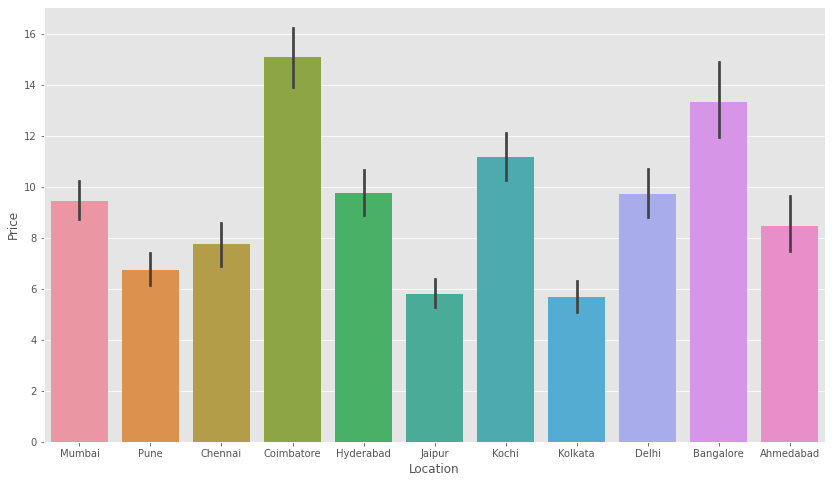

In [74]:
plt.rcParams['figure.figsize'] = [14,8]
plt.xlabel('Location')
plt.ylabel('Price')
sns.barplot(x="Location", y="Price", data=train_data)
plt.show()

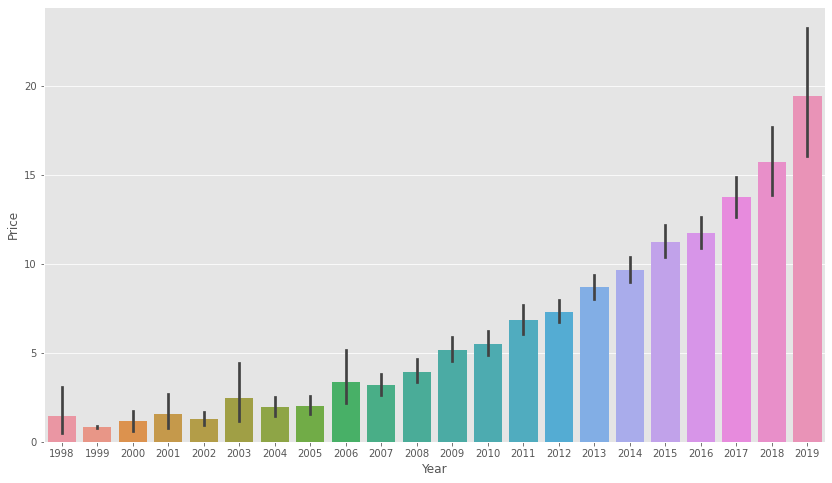

In [75]:
plt.rcParams['figure.figsize'] = [14,8]
plt.xlabel('Year')
plt.ylabel('Price')
sns.barplot(x="Year", y="Price", data=train_data)
plt.show()

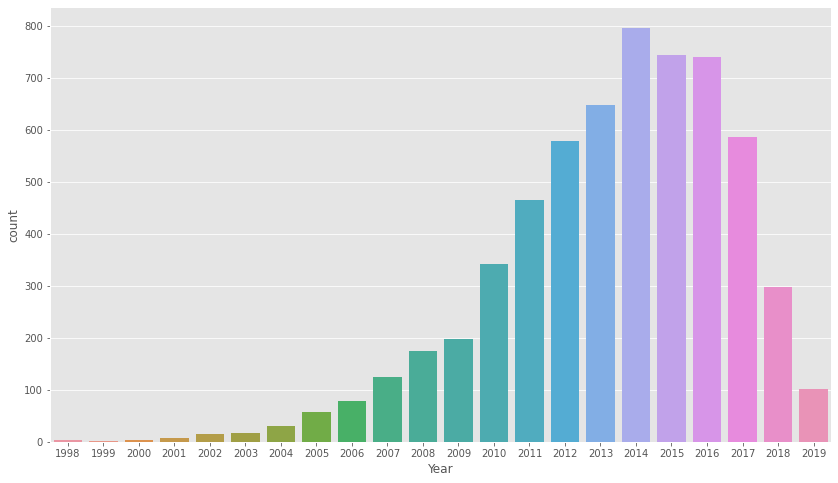

In [76]:
plt.rcParams['figure.figsize'] = [14,8]
plt.xlabel('Year')
plt.ylabel('Price')
sns.countplot('Year', data=train_data)
plt.show()

In [77]:
train_data.Fuel_Type.value_counts()

Diesel      3205
Petrol      2745
CNG           56
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

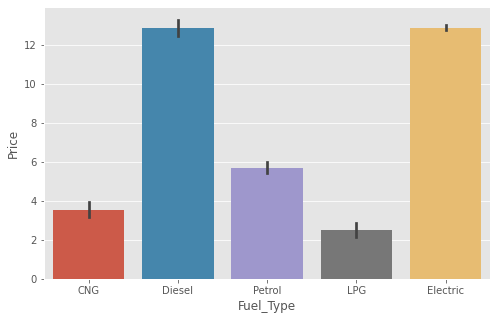

In [78]:
plt.rcParams['figure.figsize'] = [8,5]
plt.xlabel('Fuel Type')
plt.ylabel('Price')
sns.barplot(x="Fuel_Type", y="Price", data=train_data)
plt.show()

In [79]:
train_data.Transmission.value_counts()

Manual       4299
Automatic    1719
Name: Transmission, dtype: int64

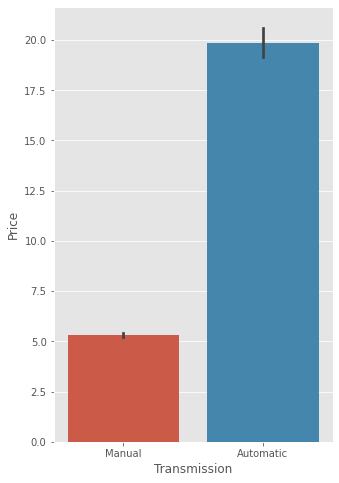

In [80]:
plt.rcParams['figure.figsize'] = [5,8]
plt.xlabel('Transmission')
plt.ylabel('Price')
sns.barplot(x="Transmission", y="Price", data=train_data)
plt.show()

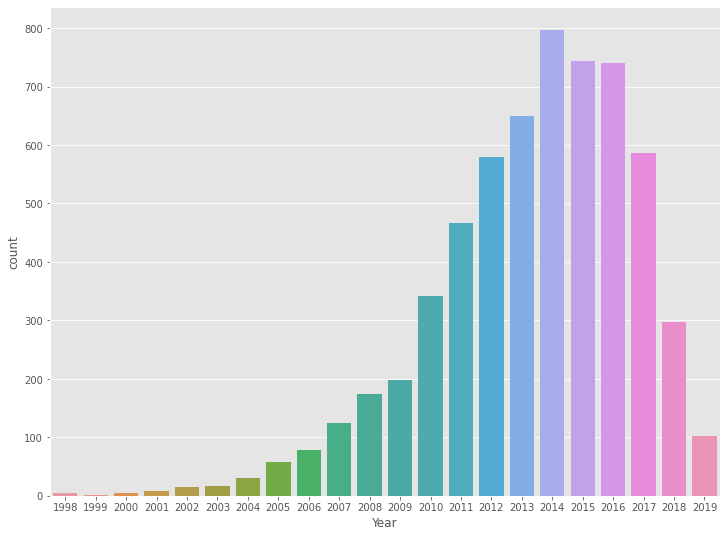

In [81]:
plt.figure(figsize=(12, 9))
sns.countplot('Year', data=train_data)
plt.show()

<AxesSubplot:xlabel='Transmission', ylabel='Price'>

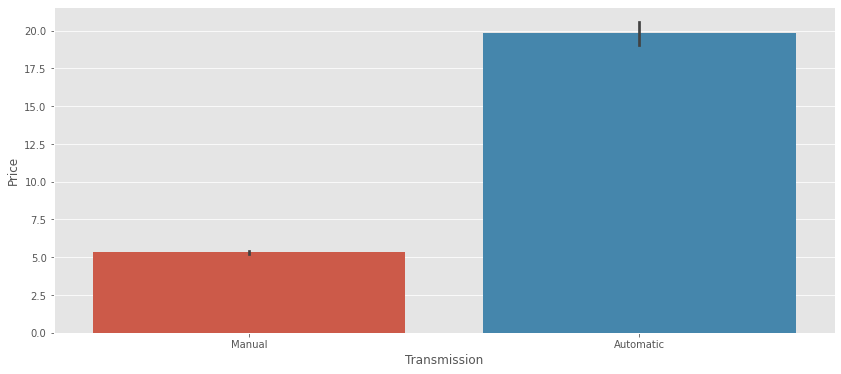

In [82]:
plt.figure(figsize=(14,6))
sns.barplot('Transmission', 'Price', data=train_data)

<AxesSubplot:xlabel='Owner_Type', ylabel='count'>

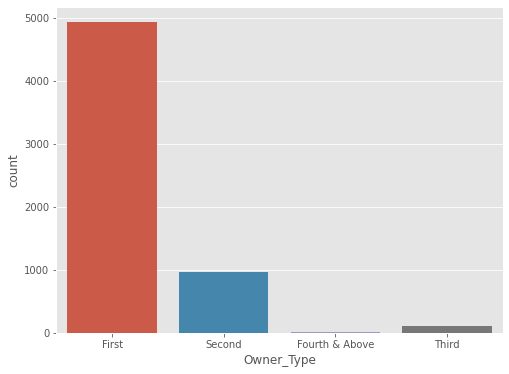

In [83]:
plt.figure(figsize=(8, 6))
sns.countplot('Owner_Type', data=train_data)

<AxesSubplot:xlabel='Owner_Type', ylabel='Price'>

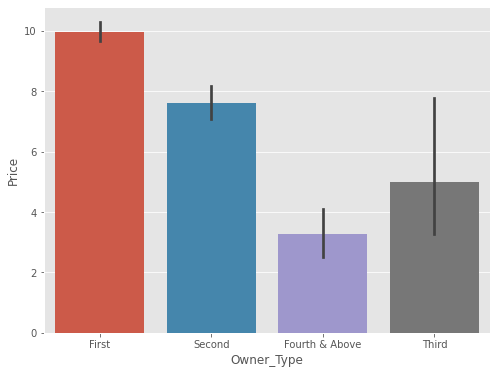

In [84]:
plt.figure(figsize=(8, 6))
sns.barplot('Owner_Type', 'Price', data=train_data)

<AxesSubplot:xlabel='Seats', ylabel='Price'>

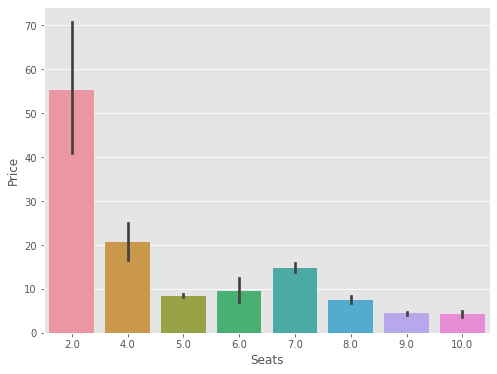

In [85]:
plt.figure(figsize=(8, 6))
sns.barplot('Seats', 'Price', data=train_data)

<AxesSubplot:xlabel='Seats', ylabel='count'>

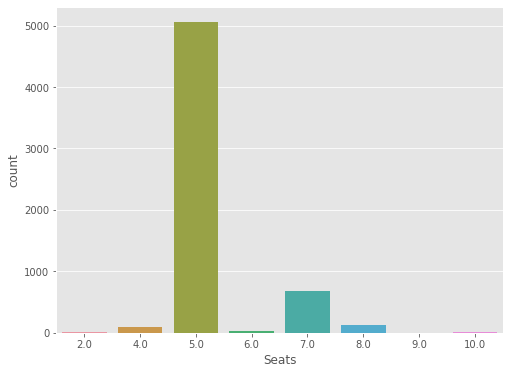

In [86]:
plt.figure(figsize=(8, 6))
sns.countplot('Seats', data=train_data)

## Feature Engineering - creating new features for making our model more and more accurate and robust.

#### We have found from EDA that cars which are Diesel, Automatic, bought after 2014, has 2 seats, bigger engine and/or more power are sold with higher price. So we create a new column for all these features.

In [87]:
post_2014 = pd.DataFrame(columns=['post_2014'])
train_data = pd.concat([train_data, post_2014], axis=1)
test_data = pd.concat([test_data, post_2014], axis=1)

for i in train_data.index:
    val = train_data['Year'][i]
    if val > 2014:
        train_data['post_2014'][i] = 1
    else:
        train_data['post_2014'][i] = 0
    

for i in test_data.index:
    val = test_data['Year'][i]
    if val > 2014:
        test_data['post_2014'][i] = 1
    else:
        test_data['post_2014'][i] = 0
        

In [88]:
is_Diesel = pd.DataFrame(columns=['is_Diesel'])
train_data = pd.concat([train_data, is_Diesel], axis=1)
test_data = pd.concat([test_data, is_Diesel], axis=1)


for i in train_data.index:
    value = train_data['Fuel_Type'][i]
    if value == 'Diesel':
        train_data['is_Diesel'][i] = 1
    else:
        train_data['is_Diesel'][i] = 0
        
        

for i in test_data.index:
    value = test_data['Fuel_Type'][i]
    if value == 'Diesel':
        test_data['is_Diesel'][i] = 1
    else:
        test_data['is_Diesel'][i] = 0

In [89]:
is_automatic = pd.DataFrame(columns=['is_automatic'])
train_data = pd.concat([train_data, is_automatic], axis=1)
test_data = pd.concat([test_data, is_automatic], axis=1)

for i in train_data.index:
    value = train_data['Transmission'][i]
    if value == 'Automatic':
        train_data['is_automatic'][i] = 1
    else:
        train_data['is_automatic'][i] = 0

        
for i in test_data.index:
    value = test_data['Transmission'][i]
    if value == 'Automatic':
        test_data['is_automatic'][i] = 1
    else:
        test_data['is_automatic'][i] = 0

In [90]:
is_2_seats = pd.DataFrame(columns=['is_2_seats'])
train_data = pd.concat([train_data, is_2_seats], axis=1)
test_data = pd.concat([test_data, is_2_seats], axis=1)

for i in train_data.index:
    value = train_data['Seats'][i]
    if value == 2:
        train_data['is_2_seats'][i] = 1
    else:
        train_data['is_2_seats'][i] = 0
        
for i in test_data.index:
    value = test_data['Seats'][i]
    if value == 2:
        test_data['is_2_seats'][i] = 1
    else:
        test_data['is_2_seats'][i] = 0

In [91]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6018 non-null   object 
 1   Year               6018 non-null   int64  
 2   Kilometers_Driven  6018 non-null   int64  
 3   Fuel_Type          6018 non-null   object 
 4   Transmission       6018 non-null   object 
 5   Owner_Type         6018 non-null   object 
 6   Mileage            6018 non-null   float64
 7   Engine             6018 non-null   int64  
 8   Power              6018 non-null   float64
 9   Seats              6018 non-null   float64
 10  Price              6018 non-null   float64
 11  post_2014          6018 non-null   object 
 12  is_Diesel          6018 non-null   object 
 13  is_automatic       6018 non-null   object 
 14  is_2_seats         6018 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 912.2+ KB


In [92]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6018 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6018 non-null   object 
 1   Year               6018 non-null   int64  
 2   Kilometers_Driven  6018 non-null   int64  
 3   Fuel_Type          6018 non-null   object 
 4   Transmission       6018 non-null   object 
 5   Owner_Type         6018 non-null   object 
 6   Mileage            6018 non-null   float64
 7   Engine             6018 non-null   int64  
 8   Power              6018 non-null   float64
 9   Seats              6018 non-null   float64
 10  Price              6018 non-null   float64
 11  post_2014          6018 non-null   object 
 12  is_Diesel          6018 non-null   object 
 13  is_automatic       6018 non-null   object 
 14  is_2_seats         6018 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 912.2+ KB


### Removed Outlier value of Kilometers driven.

In [93]:
print(train_data.shape)
temp = train_data[train_data['Kilometers_Driven'] > 400000].index
train_data.drop(temp, axis=0, inplace=True)
print(train_data.shape)

(6018, 15)
(6011, 15)


In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6011 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6011 non-null   object 
 1   Year               6011 non-null   int64  
 2   Kilometers_Driven  6011 non-null   int64  
 3   Fuel_Type          6011 non-null   object 
 4   Transmission       6011 non-null   object 
 5   Owner_Type         6011 non-null   object 
 6   Mileage            6011 non-null   float64
 7   Engine             6011 non-null   int64  
 8   Power              6011 non-null   float64
 9   Seats              6011 non-null   float64
 10  Price              6011 non-null   float64
 11  post_2014          6011 non-null   object 
 12  is_Diesel          6011 non-null   object 
 13  is_automatic       6011 non-null   object 
 14  is_2_seats         6011 non-null   object 
dtypes: float64(4), int64(3), object(8)
memory usage: 751.4+ KB


In [95]:
for i in ['post_2014', 'is_Diesel', 'is_automatic', 'is_2_seats', 
          'Mileage', 'Engine', 'Power']:
    print(i)
    train_data[i] = train_data[i].astype('float64')
    test_data[i] = test_data[i].astype('float64')

post_2014
is_Diesel
is_automatic
is_2_seats
Mileage
Engine
Power


In [96]:
print(train_data.shape, test_data.shape)
cat = train_data.select_dtypes(include='object')

for i in cat.columns:
    le = LabelEncoder()
    train_data[i] = le.fit_transform(train_data[i])
    test_data[i] = le.transform(test_data[i])
    
print(train_data.shape, test_data.shape)

(6011, 15) (1234, 14)
(6011, 15) (1234, 14)


## Normalization of various features.

In [97]:
train_target = train_data['Price']
train_data.drop('Price', axis=1, inplace=True)
means = train_data.mean()
stds = train_data.std()
train_data = (train_data - means) / stds
test_data = (test_data- means) / stds

In [98]:
print(train_data.shape)
train_data.head()

(6011, 14)


,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,post_2014,is_Diesel,is_automatic,is_2_seats
0,1.142891,-1.026682,0.440469,-1.570056,0.632035,-0.464009,3.936569,-1.033562,-1.010905,-0.345781,-0.834834,-1.067219,-0.632035,-0.051657
1,1.481244,0.501948,-0.477719,-0.905576,0.632035,-0.464009,0.329035,-0.060477,0.259433,-0.345781,1.197644,0.936859,-0.632035,-0.051657
2,-1.225580,-0.720956,-0.329624,1.087863,0.632035,-0.464009,0.001821,-0.698647,-0.440709,-0.345781,-0.834834,-1.067219,-0.632035,-0.051657
3,-1.225580,-0.415230,0.884753,-0.905576,0.632035,-0.464009,0.553995,-0.617002,-0.439589,2.141936,-0.834834,0.936859,-0.632035,-0.051657
4,-0.887227,-0.109504,-0.487493,-0.905576,-1.581928,1.978335,-0.611705,0.582692,0.532021,-0.345781,-0.834834,0.936859,1.581928,-0.051657


In [99]:
print(test_data.shape)
test_data.head()

(1234, 14)


,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,post_2014,is_Diesel,is_automatic,is_2_seats
0,-0.548874,0.196222,-0.479822,-1.570056,0.632035,-0.464009,5.557097,-1.033562,-1.010158,-1.589639,-0.834834,-1.067219,-0.632035,-0.051657
1,-0.887227,-0.109504,-0.078070,1.087863,0.632035,1.978335,1.228874,-1.370142,-1.213666,-0.345781,-0.834834,-1.067219,-0.632035,-0.051657
2,1.142891,1.113400,-0.685051,-0.905576,0.632035,-0.464009,-0.898017,1.290845,0.662714,2.141936,1.197644,0.936859,-0.632035,-0.051657
3,-0.210521,-0.415230,2.424939,-0.905576,0.632035,-0.464009,1.126619,-0.423718,-0.715165,-0.345781,-0.834834,0.936859,-0.632035,-0.051657
4,1.142891,0.196222,-0.833146,1.087863,0.632035,-0.464009,0.001821,-0.701980,-0.549931,-0.345781,-0.834834,-1.067219,-0.632035,-0.051657


## Model Training

In [100]:
X_train, X_dev, y_train, y_dev = train_test_split(train_data, train_target, test_size=0.15, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)

(5109, 14)
(5109,)
(902, 14)
(902,)


In [101]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict training data
y_pred_lr_train = lr.predict(X_train)

# Evaluation training data
print("MSE on Training Set (Linear Regression):", mean_squared_error(y_pred_lr_train, y_train))

# Predict dev data
y_pred_lr_dev = lr.predict(X_dev)

# Evaluation dev data
print("MSE on Dev Set (Linear Regression):", mean_squared_error(y_pred_lr_dev, y_dev))

MSE on Training Set (Linear Regression): 37.04042949937764
MSE on Dev Set (Linear Regression): 30.742740936398754


In [102]:
# Decision Tree
dt = DecisionTreeRegressor(splitter='best', max_depth=5)
dt.fit(X_train, y_train)

# Predict training data
y_pred_dt_train = dt.predict(X_train)

# Evaluation training data
print("MSE on Training Set (Decision Tree):", mean_squared_error(y_pred_dt_train, y_train))

# Predict dev data
y_pred_lr_dev = dt.predict(X_dev)

# Evaluation dev data
print("MSE on Dev Set (Decision Tree):", mean_squared_error(y_pred_lr_dev, y_dev))

MSE on Training Set (Decision Tree): 20.17105705722395
MSE on Dev Set (Decision Tree): 27.91493508020873


In [103]:
# Random Froest
rf = RandomForestRegressor(n_estimators=20, max_depth=5)
rf.fit(X_train, y_train)

# Predict training data
y_pred_rf_train = rf.predict(X_train)

# Evaluation training data
print("MSE on Training Set (Random Forest):", mean_squared_error(y_pred_rf_train, y_train))

# Predict dev data
y_pred_rf_dev = rf.predict(X_dev)

# Evaluation dev data
print("MSE on Dev Set (Random Forest):", mean_squared_error(y_pred_rf_dev, y_dev))

MSE on Training Set (Random Forest): 16.397969204332078
MSE on Dev Set (Random Forest): 16.729469783601047


In [104]:
# Random Forest with Grid Search
rf = RandomForestRegressor(random_state=42)

param_grid = {
    "criterion": ['mse', 'mae'],
    "n_estimators": [5, 10, 15, 20, 25, 30],
    "max_depth": [5, 6, 7, 12, 13, 15]
}

rf_model = GridSearchCV(estimator=rf, cv=5, param_grid=param_grid, verbose=2)
rf_model.fit(train_data, train_target)
print(rf_model.best_score_)
print(rf_model.best_estimator_.get_params())

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END .........criterion=mse, max_depth=5, n_estimators=5; total time=   0.0s
[CV] END .........criterion=mse, max_depth=5, n_estimators=5; total time=   0.0s
[CV] END .........criterion=mse, max_depth=5, n_estimators=5; total time=   0.0s
[CV] END .........criterion=mse, max_depth=5, n_estimators=5; total time=   0.0s
[CV] END .........criterion=mse, max_depth=5, n_estimators=5; total time=   0.0s
[CV] END ........criterion=mse, max_depth=5, n_estimators=10; total time=   0.1s
[CV] END ........criterion=mse, max_depth=5, n_estimators=10; total time=   0.1s
[CV] END ........criterion=mse, max_depth=5, n_estimators=10; total time=   0.1s
[CV] END ........criterion=mse, max_depth=5, n_estimators=10; total time=   0.1s
[CV] END ........criterion=mse, max_depth=5, n_estimators=10; total time=   0.1s
[CV] END ........criterion=mse, max_depth=5, n_estimators=15; total time=   0.1s
[CV] END ........criterion=mse, max_depth=5, n_

In [105]:
# XGBoost
xgbmodel = xgb.XGBRegressor(n_estimators=15, 
                             eta=0.2, gamma=1, max_depth=10, 
                             reg_lambda=1)
xgbmodel.fit(X_train, y_train)

# Predict training data
y_pred_xg_train = xgbmodel.predict(X_train)

# Evaluation training data
print("MSE on Training Set (XGBoost):", mean_squared_error(y_pred_xg_train, y_train))

# Predict dev data
y_pred_xg_dev = xgbmodel.predict(X_dev)

# Evaluation dev data
print("MSE on Dev Set (XGBoost):", mean_squared_error(y_pred_xg_dev, y_dev))

MSE on Training Set (XGBoost): 2.2255533684821684
MSE on Dev Set (XGBoost): 11.088644227542447
